In [2]:
import pandas as pd
from fbprophet import Prophet
import pandas
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.idracdemo import *
import seaborn as sns
import pytz
%matplotlib inline

# Setup the Connection with pravega and Read System Usage

In [10]:
idracdata = IdracData(scope='idracdemo', stream='idracdata', gateway='pravega-grpc-gateway:80')
stream_start, stream_end = idracdata.get_stream_start_end()

In [11]:
# pandas.set_option("display.max_rows", None)
reports = []
read_events = idracdata.get_data_from_idrac_generator_bymetric_id(from_stream_cut=stream_start,
                                                                  to_stream_cut=stream_end,
                                                                  data_id='CUPS',
                                                                  rack_label='nightshift',
                                                                  metric_id='SystemUsage')
for _report in read_events:
    reports.append(_report)
    


In [12]:
display(pandas.DataFrame.from_dict(reports, orient='columns').tail())

,Timestamp,RemoteAddr,Id,MetricId,avg
10311,2020-04-29T04:05:35.592Z,10.243.19.202,CUPS,SystemUsage,16.500000
10312,2020-04-29T04:05:44.502Z,10.243.19.207,CUPS,SystemUsage,16.500000
10313,2020-04-29T04:05:46.332Z,10.243.19.211,CUPS,SystemUsage,16.166667
10314,2020-04-29T04:05:50.441Z,10.243.19.209,CUPS,SystemUsage,15.769231
10315,2020-04-29T04:05:58.358Z,10.243.19.200,CUPS,SystemUsage,15.750000


# Re-Arrange the data(timstap ->ds ; measurement -> y)

In [7]:
df = pandas.DataFrame.from_dict(reports, orient='columns')
df['Timestamp'] = pandas.to_datetime(df['Timestamp'],
                               format="%Y-%m-%dT%H:%M:%S.%fZ")
df.rename(columns = {'Timestamp':'ds'}, inplace = True)
df.rename(columns = {'avg':'y'}, inplace = True)
del df['RemoteAddr']
del df['Id']
del df['MetricId']


In [8]:
df.head()

,ds,y
0,2020-04-28 16:32:12.665,21.333333
1,2020-04-28 16:32:56.157,15.916667
2,2020-04-28 16:33:01.165,17.083333
3,2020-04-28 16:33:02.196,23.500000
4,2020-04-28 16:32:40.987,18.166667


## We fit the model by instantiating a new Prophet object.

In [9]:
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made.

In [8]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
61776,2020-04-30 18:01:18.940
61777,2020-05-01 18:01:18.940
61778,2020-05-02 18:01:18.940
61779,2020-05-03 18:01:18.940
61780,2020-05-04 18:01:18.940


# Build the Prediction
- The predict method will assign each row in future a predicted value which it names yhat.
- The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
61776,2020-04-30 18:01:18.940,28.756242,5.878699,53.432568
61777,2020-05-01 18:01:18.940,51.373909,16.203135,89.640780
61778,2020-05-02 18:01:18.940,60.949843,11.305608,113.960074
61779,2020-05-03 18:01:18.940,71.279435,8.460449,143.833167
61780,2020-05-04 18:01:18.940,76.217871,-3.768084,163.064627


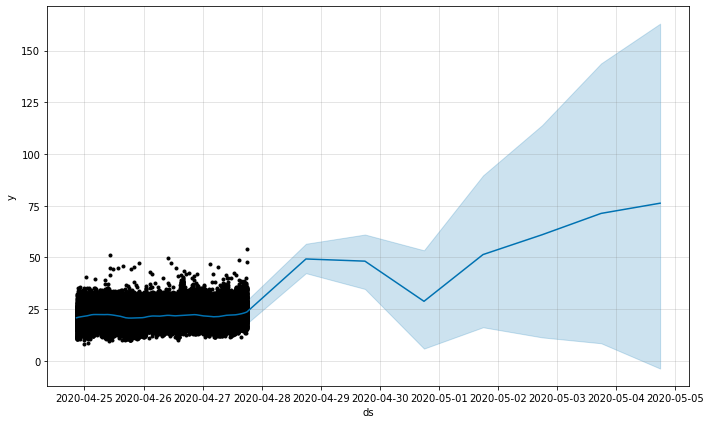

In [10]:
fig1 = m.plot(forecast)

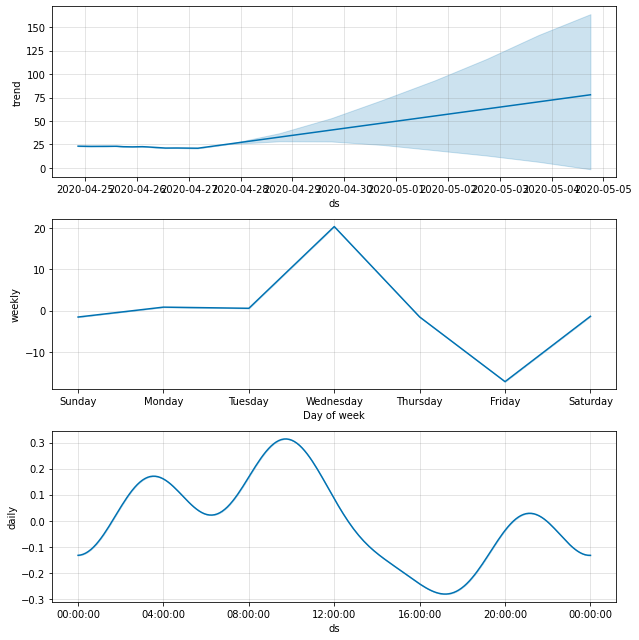

In [11]:
fig2 = m.plot_components(forecast)